In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom as pdicom
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

from PIL import Image
from collections import Counter
from natsort import natsorted

import keras
from keras.preprocessing.image import array_to_img

# from utils import clean_slice

Using TensorFlow backend.


In [2]:
#list all dicom images
dicom_path = "Dataset"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(dicom_path):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
            #print(lstFilesDCM)
natsorted(lstFilesDCM)
print("Number of all files: ", len(lstFilesDCM))

ct_paths = []
for e in lstFilesDCM:
    if e.split('/')[-1][:2]=="CT":
        ct_paths.append(e)
        
print("Number of CT files: ", len(ct_paths))
    

Number of all files:  8122
Number of CT files:  2860


In [3]:
RefDs = pdicom.read_file(ct_paths[0])
print(RefDs)

# RefDsList = []
# for elem in ct_paths:
#     RefDsList.append(pdicom.read_file(elem))
    
# RefDsList

(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0012) Instance Creation Date              DA: '20181018'
(0008, 0013) Instance Creation Time              TM: '070123'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.65763.30000017071308013339600001230
(0008, 0020) Study Date                          DA: '20170713'
(0008, 0021) Series Date                         DA: '20170713'
(0008, 0022) Acquisition Date                    DA: '20170713'
(0008, 0023) Content Date                        DA: '20170713'
(0008, 0030) Study Time                          TM: '110508.577'
(0008, 0031) Series Time                         TM: '111434.29'
(0008, 0032) Acquisition Time                    TM: '111425.167'
(0008, 0033) Content Time                        TM: '111425.167'
(0008, 00

In [ ]:
arr_shapes = []
d = dict()
# loop through all the DICOM files
for filenameDCM in tqdm(ct_paths):
    if "Image" not in filenameDCM:
        continue
    # read the file
    ds = pdicom.read_file(filenameDCM)
    arr_shapes.append(ds.pixel_array.shape)
    shape = ds.pixel_array.shape
    if shape in d.keys():
        d[shape].append(filenameDCM)
    else:
        d[shape] = [filenameDCM]
print(len(arr_shapes))
Counter(arr_shapes)

 40%|████      | 1145/2860 [00:05<00:08, 192.27it/s]

In [ ]:
from typing import List
def sort_paths(paths: List[str]) -> List[str]:  
    """
    Augmented natural sorting to group together brain 
    slices upto TWO per patient
    """
    ct_paths_sorted = natsorted(paths)
    curr_patient_id = ct_paths_sorted[0].split('/')[-2]
    fst = []
    snd = []
    ct_sorted = []
    for i in range(len(ct_paths_sorted)-1):
        if '_' in ct_paths_sorted[i].split('/')[-1]:
            snd.append(ct_paths_sorted[i])
        else:
            fst.append(ct_paths_sorted[i])

        patient_id = ct_paths_sorted[i].split('/')[-2]
        if patient_id!=curr_patient_id:
            ct_sorted += fst + snd
            fst = []
            snd = []
            curr_patient_id = patient_id
    return ct_sorted
from utils import sort_paths
ct_paths_sorted = sort_paths(d[(512,512)])

In [34]:
slice2brain_id = []
for e in ct_paths_sorted:
    slice2brain_id.append(e.split('/')[-2])
Counter(slice2brain_id)

Counter({'339663': 77,
         '345923': 72,
         '346231': 69,
         '351423': 170,
         '353891': 65,
         '354152': 75,
         '361113': 68,
         '362946': 65,
         '363578': 73,
         '363740': 69,
         '378104': 118,
         '379682': 386,
         '380225': 77,
         '380677': 61,
         '383593': 270,
         '385185': 71,
         '385948': 70,
         '386346': 76,
         '386348': 133,
         '386661': 71,
         '386662': 70,
         '386800': 82,
         '386801': 77,
         '387098': 66,
         '387295': 67,
         '387404': 66,
         '387607': 72,
         '387719': 74,
         '387722': 73,
         '388070': 77})

In [7]:
arr = np.zeros((512, 512, len(ct_paths_sorted)))

for i in tqdm(range(len(ct_paths_sorted))):
    ds = pdicom.read_file(ct_paths_sorted[i]) 
    arr[:, :, i] = ds.pixel_array 
#     break
len(arr)

100%|██████████| 2860/2860 [00:13<00:00, 206.91it/s]


512

In [8]:
print(arr.dtype)
print(arr.shape)
print(np.max(arr))
print(np.min(arr))
print("mean: ", np.mean(arr))
print("n pixels less than 5: ", np.sum(arr<5))
print("n pixels more than 5: ", np.sum(arr>=5))
print("mean of pixels greater than 5: ", np.mean(arr[arr>5]))
print("std of pixels greater than 5: ", np.std(arr[arr>5]))

float64
(512, 512, 2860)
8000.0
0.0
mean:  251.87979103168408
n pixels less than 5:  476745283
n pixels more than 5:  272986557
mean of pixels greater than 5:  753.7770771171793
std of pixels greater than 5:  601.1343245468303


<Figure size 432x288 with 0 Axes>

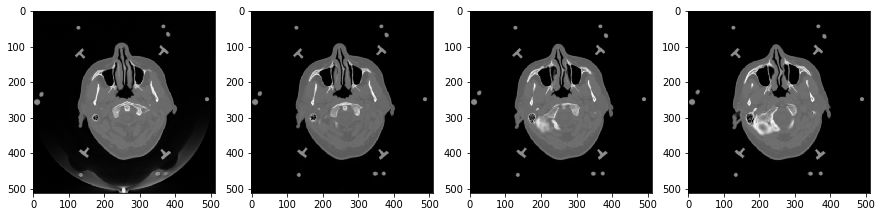

In [9]:
n_slices_to_plot = 4
n_rows = n_slices_to_plot // 4 + 1

plt.set_cmap(plt.gray())
fig = plt.figure(figsize=(15, 17))
for i in range(n_slices_to_plot):
    plt.subplot(n_rows, 4, i + 1)
    plt.imshow(arr[:,:,i])
plt.show()

In [10]:
# im = array_to_img(ArrayDicom[:,:,1].reshape(512, 512, -1)) 
# IMG_SIZE = 224      

# new_size = tuple([int(x*(float(IMG_SIZE)/max(im.size))) for x in im.size])
# im_resized       = im.resize(new_size, Image.ANTIALIAS)
# new_im   = Image.new("L", (IMG_SIZE, IMG_SIZE))
# new_im.paste(im_resized, 
#              ((IMG_SIZE-new_size[0])//2,
#               (IMG_SIZE-new_size[1])//2))

# resized_image = np.array(new_im).reshape(224, 224, 1)
# array_to_img(resized_image) 

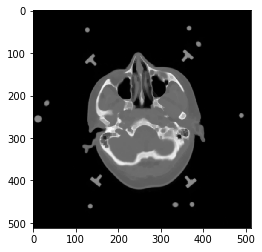

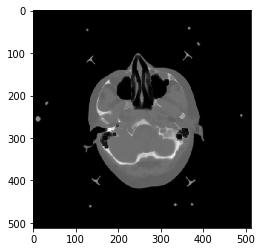

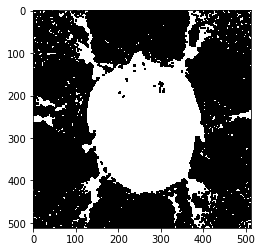

In [11]:
kernel = np.ones((5,5),np.uint8)
img = arr[:,:,7]
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
erode = cv2.erode(img, kernel, iterations = 1)
# dilation2 = cv2.dilate(closing,kernel,iterations = 1)
thres = erode>0
thres = np.array(thres, dtype=np.uint8)
plt.imshow(closing)
plt.show()
plt.imshow(erode)
plt.show()
plt.imshow(thres)

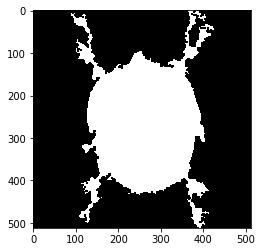

In [12]:
mask = np.zeros(img.shape,np.uint8)
imgg, contours, hier = cv2.findContours(thres,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
areas = []
for cnt in contours:
    areas.append(cv2.contourArea(cnt))

index = areas.index(max(areas))
cnt = contours[index]
mask = cv2.drawContours(mask,[cnt],0,255,-1)
plt.imshow(mask)

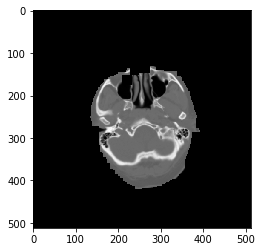

In [13]:
def clean_slice(img, erode_iter = 6, dilate_iter = 1):
    """
    too much noise remains -> increase erode_iter
    too little brain left -> increase dilate_iter
    returns 2D array
    
    """
    img = img.copy()
    kernel = np.ones((5,5),np.uint8)
    if len(img.shape)==3:
        img = img[:,:,0]
    img_morph = cv2.erode(img, kernel, iterations = erode_iter)
    thres = img_morph>0
    thres = np.array(thres, dtype=np.uint8)
    
    mask = np.zeros(thres.shape, np.uint8)
    imgg, contours, hier = cv2.findContours(thres,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    areas = []
    for cnt in contours:
        areas.append(cv2.contourArea(cnt))
        
    index = areas.index(max(areas))
    cnt = contours[index]
    mask = cv2.drawContours(mask,[cnt],0,255,-1)
    mask = cv2.dilate(mask, kernel,iterations = dilate_iter)
    mask = mask>1
    img[~mask] = 0
    
    return img

a= clean_slice(img)
plt.imshow(a)

<Figure size 432x288 with 0 Axes>

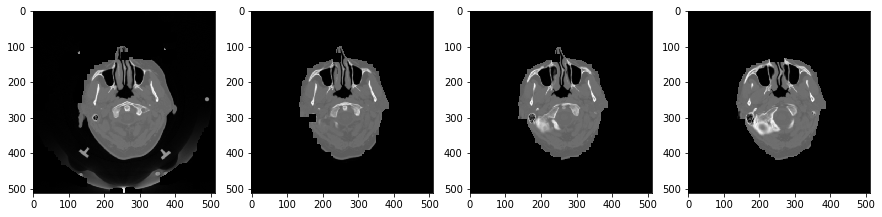

In [14]:
n_slices_to_plot = 4
n_rows = n_slices_to_plot // 4 + 1

plt.set_cmap(plt.gray())
fig = plt.figure(figsize=(15, 17))
for i in range(n_slices_to_plot):
    plt.subplot(n_rows, 4, i + 1)
    img = clean_slice(arr[:,:,i])
    plt.imshow(img)
plt.show()

In [24]:
for i in range(len(ct_paths_sorted)-1):
    a = int(ct_paths_sorted[i].split("Image")[-1].split('.')[0].strip())
    b = int(ct_paths_sorted[i+1].split("Image")[-1].split('.')[0].strip())
    if a>b:
        print("#"*12)
        print(ct_paths_sorted[i])
        print(ct_paths_sorted[i+1])
    
    

############
Dataset/339663/CT.339663.Image 98.dcm
Dataset/345923/CT.345923.Image 1.dcm
############
Dataset/345923/CT.345923.Image 72.dcm
Dataset/346231/CT.346231.Image 1.dcm
############
Dataset/346231/CT.346231.Image 69.dcm
Dataset/351423/CT.351423.Image 2.dcm


ValueError: invalid literal for int() with base 10: '4_0001'

In [32]:
curr_patient_id = ct_paths_sorted[0].split('/')[-2]
fst = []
snd = []
ct_sorted = []
for i in range(len(ct_paths_sorted)-1):
    if '_' in ct_paths_sorted[i].split('/')[-1]:
        snd.append(ct_paths_sorted[i])
    else:
        fst.append(ct_paths_sorted[i])

    patient_id = ct_paths_sorted[i].split('/')[-2]
    if patient_id!=curr_patient_id:
        ct_sorted += fst + snd
        fst = []
        snd = []
        curr_patient_id = patient_id
        
ct_sorted

['Dataset/339663/CT.339663.Image 22.dcm',
 'Dataset/339663/CT.339663.Image 23.dcm',
 'Dataset/339663/CT.339663.Image 24.dcm',
 'Dataset/339663/CT.339663.Image 25.dcm',
 'Dataset/339663/CT.339663.Image 26.dcm',
 'Dataset/339663/CT.339663.Image 27.dcm',
 'Dataset/339663/CT.339663.Image 28.dcm',
 'Dataset/339663/CT.339663.Image 29.dcm',
 'Dataset/339663/CT.339663.Image 30.dcm',
 'Dataset/339663/CT.339663.Image 31.dcm',
 'Dataset/339663/CT.339663.Image 32.dcm',
 'Dataset/339663/CT.339663.Image 33.dcm',
 'Dataset/339663/CT.339663.Image 34.dcm',
 'Dataset/339663/CT.339663.Image 35.dcm',
 'Dataset/339663/CT.339663.Image 36.dcm',
 'Dataset/339663/CT.339663.Image 37.dcm',
 'Dataset/339663/CT.339663.Image 38.dcm',
 'Dataset/339663/CT.339663.Image 39.dcm',
 'Dataset/339663/CT.339663.Image 40.dcm',
 'Dataset/339663/CT.339663.Image 41.dcm',
 'Dataset/339663/CT.339663.Image 42.dcm',
 'Dataset/339663/CT.339663.Image 43.dcm',
 'Dataset/339663/CT.339663.Image 44.dcm',
 'Dataset/339663/CT.339663.Image 4